# Building an Image Classifier from Scratch (Part 2)
This post is long, but it really helped me understand the core elements of deep learning. I originally hoped to build my image classifier with a neural net by the end of this post, but things got a little out of hand. Additionally, I don't like the way PDLC introduced neural nets at the end of chapter 4. It was very cavalier and I don't quite understand the rationale at this point. So, I will fix that problem before writing about it (or during writing about it). At the very least, I have developed a model that does slightly better at identifying an Arsenal or Liverpool logo than my last post. Progress is progress I guess.

### Pre-processing
The following block of code imports all of the images I will be using to train and validate the model and gets them in the appropriate tensor format.

In [127]:
from fastai.vision.all import *
import torch
import torchvision.transforms as transforms

target_size = (140, 140)
resize_tranform = transforms.Compose([transforms.Resize(target_size),transforms.ToTensor()])

arsenal = Path("/Users/jbackon/Pictures/archive/epl-logos-big/epl-logos-big/arsenal").ls().sorted()
arsenal_tensors = [resize_tranform(Image.open(o)) for o in arsenal]
stacked_arsenal = torch.stack(arsenal_tensors).float()/255

liverpool = Path("/Users/jbackon/Pictures/archive/epl-logos-big/epl-logos-big/liverpool").ls().sorted()
liverpool_tensors = [resize_tranform(Image.open(o)) for o in liverpool]
stacked_liverpool = torch.stack(liverpool_tensors).float()/255

As a reminder, since the image set I am using did not include a validation set, I need to create one. I will actually be using the training and validation sets in the model below so this is a mandatory step for this post.

In [128]:
from sklearn.model_selection import train_test_split

ars_train, ars_valid = train_test_split(stacked_arsenal, test_size=0.2, random_state=42)

liv_train, liv_valid = train_test_split(stacked_liverpool, test_size=0.2, random_state=42)
liv_train.shape, liv_valid.shape

(torch.Size([800, 4, 140, 140]), torch.Size([200, 4, 140, 140]))

### The Linear Model
At the risk of stating the obvious, I want to be very clear about why the model I am about to build is called a "linear" model. The general method I am about to employ is:
- Take the set of color information for each pixel (the independent variable x)
- Multiply x by a set of parameters or weights (w)
- See if the result corresponds to an Arsenal image or a Liverpool image (the dependent variable y) based on a loss function I will need to define.
- Determine if that result is correct.
- Adjust the weights to create better predictions and repeat the above process.

In other words, I am checking if y = wx. To ensure there are no zero values in the event x is zero, I will add a constant (b) known as the "bias". This means I am calculaing y = wx + b for every pixel in each image. This equation is one everyone knows and loves from grade school. It's the equation of a line and the reason we call this a "linear" model.

### Image Flattening
Using a linear model to categorize my color logos has one major drawback. In order to continue, I am going to combine the Arsenal and Liverpool training sets and then "flatten" them. This is necessary since both training tensors are rank 4 (800, 4, 140, 140) and the multiplication I will be doing is expecting a vector or a tensor of rank 2. In other words, I need my independent variable to have a shape like (1600, n) where n is somehow related to the image. The way to flatten my training data is to multiply all of the data associated with each axis to produce a single value that represents all of the "information" for each image. This will give me a vector that looks like (1600, 140x140x4) or (1600, 78400).

The problem with this is that, even though the information that describes each pixel is preserved, the shape of the image is lost. I suspect this causes some of the issues with training that we will see later. I did a little research and there are ways to do this that preserve the shape of the image. Specifically, a technique known as convolutional neural nets, but I need to walk before I run and so I will stick to the basics in order to strengthen my fundamentals.

### Variable Definitions
The code below creates the independent variable (x) for my training set.

In [129]:
train_x = torch.cat([ars_train, liv_train]).view(1600, -1)
train_x.shape

torch.Size([1600, 78400])

torch.cat concatenates the two lists together and then .view does the flattening where the arguments (1600, -1) tell pytorch to use the 1600 images and then make the second dimension as large as needed to fit the remaining data. 

Now that I have the independent variables ready to go, I need to prepare the dependent variables. Since the computer won't be able to multiply a number by the word "Arsenal" or "Liverpool", I need to represent these strings with integers. The line of code below creates a tensor of 1's and 0's that matches the corresponding number of labels for each image. Each 1 will correspond to an Arsenal image and each 0 a Liverpool image. I will use these values to tell the model if its predictions are correct or not. The .unsqueeze(1) ensures that the size of the 2nd dimension in our resulting tensor is always 1. 

In [130]:
train_y = tensor([1]*len(ars_train) + [0]*len(liv_train)).unsqueeze(1)
train_y.shape

torch.Size([1600, 1])

Finally, I will combine our train_x and train_y into a single dataset where each image and it's corresponding label are represented as a tuple. The first value in the tuple is a list of all 78,400 pixel values associated with each image, and the second value is a  1 or a 0 depending on whether the image is an Arsenal logo or a Liverpool logo. I will use this later to take advantage of some of the methods built into fastai.

In [131]:
dset = list(zip(train_x,train_y))
len(dset)

1600

I need to repeat all of the above steps for our validation tensors. I'll use these to determine the accuracy of the model after I've trained it.

In [132]:
valid_x = torch.cat([ars_valid, liv_valid]).view(400, -1)
valid_y = tensor([1]*len(ars_valid) + [0]*len(liv_valid)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

### Parameters
Now that I've defined our independent and dependent variables, I need to set our initial parameters in order to start making predictions. Below is a function that will randomly generate as many parameters as I want to create. The .requires_grad() method at the end tells pytorch that we will be using these values to calculate gradients in the future. 

In [133]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

I will now set my initial parameters as well as the bias. I need a weight for every piece of information associated with each pixel in each image. So, 78,400 weights plus 1 bias value.

In [134]:
weights = init_params((140*140*4,1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([78400, 1]), torch.Size([1]))

Now, I can finally create the linear model. It is in this step that I will be utilizing another clever mathematical trick to speed up the calculations. Matrix multiplication is the operation represented by the '@' symbol in the function below. Consider that 'xb' represents a matrix that has 1600 rows and 78,400 columns. Each value in the matrix is a piece of information about one of the images. 'weights' is a matrix that has 78,400 rows and 1 column. The values of this matrix represent the weights we will be multiplying our training data by. This gives us an operation that looks like:

[1600 x 78,400] x [78,400 x 1]

The result will be a matrix or vector of shape [1600, 1] which means we will have a single value associated with each image. We are going to call these values our predictions and use them to train our model.

In [135]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds, preds.shape

(tensor([[1.3204],
         [1.9149],
         [1.7767],
         ...,
         [1.6026],
         [1.3365],
         [2.3007]], grad_fn=<AddBackward0>),
 torch.Size([1600, 1]))

### The Loss Function
The first thing I want to do now that I have a set of predictions is see how "good" they are. In order to do this though, I need some way to determine how "far off" each prediction is from the actual logo. In other words, if the model was supposed to predict a 1 for an Arsenal image, I need to know how "far away" from 1 the prediction is. This can be done with the simple caluclation (1 - prediction). If the image was supposed to be a 0, then I can just leave the value as is since any values "distance" to 0 is just the value itself. 

Before I do this, I have a small problem. Some of the predictions are positive and some are negative. This is because I randomly created a set of weights and some of them were negative. I want all of the predictions to be between 0 and 1 or the "distances" won't be accurate. For example, (1 - (-weight)) will provide a distance greater than 1 which the model won't know how to handle. 

To solve this problem, I introduce the sigmoid function. The sigmoid function looks like this:

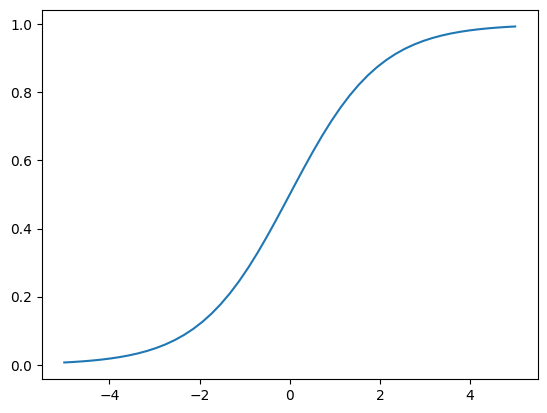

In [136]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5,5)
y = 1/(1+(np.exp(-x)))
plt.plot(x, y)

All values of the sigmoid function are betwen 0 and 1 which is perfect for this use case. Now I can build the loss function. To do so there are a few things I have to keep track of:
- First, I have to take the results of the linear model and get them between 0 and 1. I can use the sigmoid function for this.
- Second, I have to decide if the image being modeled is actually an Arsenal logo (1) or a Liverpool logo (0). 
- If the result is supposed to be a 1, I will need to determine how far the prediction is from 1 by taking (1 - prediction).
- If the result is supposed to be a 0, then I will just return the value of the prediction.

Pytorch has a method called "where" that takes care of this conditional for me. It basically says: if the image is an Arsenal logo return (1-prediction) otherwise just return the prediction because it was supposed to be a Liverpool logo. The last piece of the function takes the average of all of the loss calculations to get an overall loss for the model in its current state. I hope to improve or decrease this value with gradient descent.

In [137]:
def logo_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()


### The First Run
I now have all of the pieces I need to train the model. To see how this works, I'll go through one round of training step by step. 

First, I set the initial parameters. I've included some summary statistics to see how the gradients affect our parameters after I do a round of gradient descent.

In [138]:
weights = init_params((140*140*4,1))
bias = init_params(1)

w1_mean = weights.mean().item()
w1_std = weights.std().item()
w1_min = weights.min().item()
w1_max = weights.max().item()
w1_median = weights.median().item()

print(f"Mean: {w1_mean:.4f}")
print(f"Std: {w1_std:.4f}")
print(f"Min: {w1_min:.4f}")
print(f"Max: {w1_max:.4f}")
print(f"Median: {w1_median:.4f}")

Mean: 0.0005
Std: 1.0001
Min: -4.1041
Max: 4.1935
Median: 0.0004


Next, I'm going to create a "batch". A batch is a subset of the training data. In the "real world", people would have enormous data sets and training models on the entire set would take too long. They can also take advantage of the parallel processing of a GPU if they break their training set into groups of smaller sets and allow the GPU to process multiple batches at a time. 

For the purposes of this demonstration, I'm going to use a tiny batch size of 4.

In [139]:
batch = train_x[:4]
batch.shape

torch.Size([4, 78400])

Now that I have my independent variable and my weights, I can run my linear model and get my first set of predictions. I haven't run the values through the sigmoid function yet, so some values will fall outside of [0,1].

In [140]:
preds = linear1(batch)
preds

tensor([[-0.9542],
        [-0.6874],
        [-0.2498],
        [-0.3098]], grad_fn=<AddBackward0>)

The next step is to calcuate the loss on the first set of predictions. 

In [141]:
loss = logo_loss(preds, train_y[:4])
loss

tensor(0.6316, grad_fn=<MeanBackward0>)

I'm almost there. Now for the actual learning part. The next step is to calculate the gradients of the loss function. I'll use these values to update the parameters and run the model again. If all goes well, the loss will go down. This step is crucial and due to the prevelance of 0's in the image data sets themselves I wanted to make sure the gradients were actually non-zero. So, I created a histogram of the graident values to prove to myself that these values will, in fact, change our initial parameters.

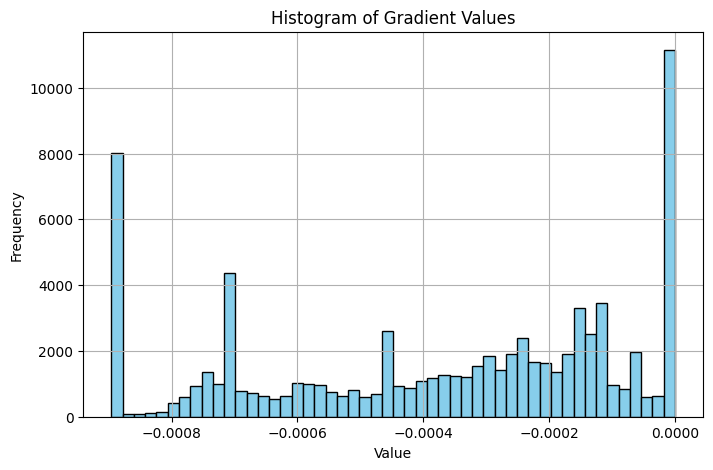

In [142]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

plt.figure(figsize=(8, 5))
plt.hist(weights.grad, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Gradient Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Now that I have a set of gradients, let's "teach" our model how to do better by updating the initial parameters and then rerun the model to see if it's actually improved. After I update our paramters, I will need to zero out the gradients or pytorch will add to the existing values when I calculate them again. This will result in meaningless gradients and throw off the model.

Keep in mind that the gradient values shown above are very small. This means there should not be a significant change to the loss value given these very small changes to the weights. I'll show the comparison statistics to show just how small the changes are.

In [143]:
params = weights, bias
for p in params:
    p.data -= p.grad
    p.grad.zero_()
    
print(f"Original Mean: {w1_mean:.4f}" " | " f"Mean after gd: {weights.mean().item():.4f}")
print(f"Original Std: {w1_std:.4f}" " | " f"Std after gd: {weights.std().item():.4f}")
print(f"Original Min {w1_min:.4f}" " | " f"Min after gd: {weights.min().item():.4f}")
print(f"Original Max {w1_max:.4f}" " | " f"Max after gd: {weights.max().item():.4f}")
print(f"Original Median {w1_median:.4f}" " | " f"Median after gd: {weights.median().item():.4f}")

Original Mean: 0.0005 | Mean after gd: 0.0009
Original Std: 1.0001 | Std after gd: 1.0001
Original Min -4.1041 | Min after gd: -4.1038
Original Max 4.1935 | Max after gd: 4.1940
Original Median 0.0004 | Median after gd: 0.0008


In [144]:
preds1 = linear1(batch)
loss1 = logo_loss(preds1, train_y[:4])
loss

tensor(0.6316, grad_fn=<MeanBackward0>)

Given how small the changes to the parameters were it's not suprising the loss didn't change. One of the things that can speed up the decrease in loss is to multiply our gradients by something called the "learning rate". This scales our gradients in a way that reduces the number of times I will need to go through the gradient descent process. Before I do this though, I'll define some things that will make the process much quicker.

### Putting Everything Together
*Note: The rest of the post closely mimics chapter 4 of PDLC. The functions below are copied from the book. The only difference (of course) are the datasets I am inputting.*

To truly train this model I want to use batch sizes larger than 4. Pytorch comes with a class that handles batches really nicely. Not only does it allow you to create batches of any size, but it will automatically randomize the values in the batches to minimze the chances of overfitting the model by training on the same set of data over and over again. This class is called the "DataLoader" and it takes a "dataset" which is a tuple of our independent and dependent variables. I created this earlier when I was preparing the data for training.

In [145]:
dl = DataLoader(dset, batch_size=200)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([200, 78400]), torch.Size([200, 1]))

I now have a batch of 200 independent and dependent variables. I'll also create a dataloader for the validation set that will be used to measure the accuracy of the model later. Since I only have 200 images in our validation set, the batch size will need to be smaller here.

In [146]:
valid_dl = DataLoader(valid_dset, batch_size=50)

Since I am going to be calculating gradients over and over again, it makes sense to write a function that takes care of this for me. Luckily, I already have all of the pieces necessary to do this. The small change we are making here is the addition of a parameter for the model and using this parameter to get our initial predictions. While we could use our linear function here, writing the function with a parameter allows us to reuse it for any model I want.

In [147]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = logo_loss(preds, yb)
    loss.backward()

Now I will create a function that takes the gradients from the "calc_grad" function and applies them to the parameters (weights and bias). This represents one "round" of training and is called an epoch. It's amazing to think that this function **IS** deep learning. If I run this function repeatedly, I should get a set of weights that accomplishes whatever task I desire. In this case, identifying whether an image is an Arsenal or Liverpool logo.

There is one important parameter to take note of: "lr" which stands for learning rate. I can use the learning rate to scale the effect of the gradients to train the model in a more optimal way. If I don't do this, then I may end up changing the weights too much and bouncing around the optimal solution without the fine tuned changes required to get there. Alternatively, the changes may be too small requiring millions of epochs to reach the "best" solution. This is also not ideal. At this point I am using trial and error to set the learning rate, but I suspect there are best practices I will learn about later to do it more intentionally. 

In [148]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

### Accuracy
The book spends a great deal of time talking about the difference between loss and accuracy. Essentially, loss is the value I am optimizing. It's what the computer understands. Accuracy is something that humans understand. It is related to the loss, but has nothing to do with the training process itself. 

I found the function below to be a little tricky, so I'm going to break it down. 
- "xb" are the predictions from our model for a given batch, "yb" are the true results for that batch (1 or 0 depending on the type of logo).
- I take the predictions and apply the sigmoid function to ensure they are between 1 and 0.
- Since this is a binary classification, I check to see if the prediction is closer to 0 or 1. It doesn't matter that the results aren't exactly 0 or 1. I wouldn't expect them to be at this stage. The result gives me a boolean and then the boolean is compared to "yb" which also returns a boolean.
- I then convert the boolean to a float and take the mean to give the percentage of correct predictions. This represents the accuracy.

Here is a quick example with random values: 

xb = 4.367

preds = 0.842

(preds > 0.5) = True

correct = True == 1 = True

correct.float() = 1.

In [149]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

I will calculate the accuracy on the validation set. That's what it's for. So, I'll create a function that applies the "batch_accuracy" function to the validation data set. The return statement below takes the list of accuracies for each batch, stacks them, and then converts them to a float in order to average them while rounding to 4 digits.

In [150]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)


I'll now use this function to see how accurate the untrained model is.

In [153]:
validate_epoch(linear1)

0.5075

51%. I'll train the model for 1 epoch and see if it changes the accuracy at all. The learning rate is set to 1, which means our gradients will be unchanged.

In [152]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5075

No change. That's ok, I'll try training the model some more. 

In [154]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1))

0.53
0.545
0.5825
0.6025
0.6225
0.6325
0.6525
0.6675
0.675
0.685
0.6925
0.6975
0.695
0.705
0.71
0.71
0.7125
0.715
0.72
0.725


Ok. The accuracy went up to 73% after 20 epochs. This is better, but not great. I could keep training the model for more epochs, or adjust the learning rate to try to get a better result faster.

Before I try again, I'm going to use a cool class that fastai built called a "learner". This class will allow me to define all of the relevant parameters to train a model and then outputs a really nice visual representation of the training process and the accuracy of the model. Here's a quick breakdown:
- "dls" is a Dataloader tuple which contains our training and validation sets.
- "nn.Linear(weights, bias)" is a built in object that fastai created to represent the linear model we built above. It handles the parameters nicely so I'll use it here.
- The "opt_func" tells the learner how to optimize the weights. "SGD" tells it to use gradient descent just like we did above.
- The "loss_func" and "metrics" are the same functions I built earlier and tell the learner how to calculate loss and accuracy. 

Let's put all of this together, reset the weights and see how training goes with with a smaller learning rate.

In [172]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(140*140*4,1), opt_func=SGD, loss_func=logo_loss, metrics=batch_accuracy)
learn.fit(20, lr=.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.504162,0.499413,0.515000,00:00
1,0.503853,0.498865,0.712500,00:00
2,0.503528,0.498318,0.795000,00:00
3,0.503187,0.497770,0.822500,00:00
4,0.502832,0.497222,0.822500,00:00
5,0.502463,0.496675,0.822500,00:00
6,0.502079,0.496127,0.835000,00:00
7,0.501681,0.495580,0.835000,00:00
8,0.501270,0.495032,0.835000,00:00
9,0.500847,0.494484,0.835000,00:00


This is not a perfect test because we've started with different weights, but the initial accuracy is almost the same as our try with a learning rate of 1 so it's close enough. As you can see we did better with a learning rate of 0.1, but we got stuck around 84% accuracy. The loss continued to drop, but the accuracy didn't change most likely due to the binary nature of our accuracy function. In other words, the changes to our predictions weren't sufficient to get enough values to cross the 0.5 threshold and thus appreciably affect the accuracy. If we continued to train the model we could probably get the accuracy to increase, but we risk over training and as I mentioned at the beginning of the post, this is not the best way to build an image classifier.

### Conclusion
One of the things I can't show in a static post,  but is worth mentioning, is how different the training behavior is depending on the initial weights and the associated initial accuracy. I ran the code above multiple times in order to get an initial accuracy that was close to my test example. During this process there were several times when the accuracy went up to 94 or 95 percent and then back down to the mid 80s. Making the learning rate .01, prevented this issue, but failed to reach the 84% accuracy within 20 epochs. 

My initial thought is to include some kind of stop condition when the accuracy hits a certain threshold. Realistically though, I suspect I have reached the limits of this particular model for this particular task. I haven't even built a neural net yet and this post is already too long. For now, I will leave this as is and perhaps return to it another day when I know more about how all of this works. 